loading Roboflow workspace...
loading Roboflow project...
[{'x': 157.5, 'y': 91.5, 'width': 151.0, 'height': 141.0, 'confidence': 0.4205891788005829, 'class': 'Skin-Lesions', 'points': [{'x': 82.58522727272728, 'y': 21.477272727272727}, {'x': 82.58522727272728, 'y': 117.61363636363636}, {'x': 85.48295454545455, 'y': 117.61363636363636}, {'x': 87.41477272727273, 'y': 118.97727272727272}, {'x': 87.41477272727273, 'y': 119.31818181818181}, {'x': 87.89772727272728, 'y': 119.6590909090909}, {'x': 89.3465909090909, 'y': 118.63636363636363}, {'x': 89.82954545454545, 'y': 118.63636363636363}, {'x': 90.3125, 'y': 118.97727272727272}, {'x': 90.3125, 'y': 124.09090909090908}, {'x': 89.82954545454545, 'y': 124.43181818181817}, {'x': 89.82954545454545, 'y': 125.11363636363636}, {'x': 90.3125, 'y': 125.45454545454544}, {'x': 90.3125, 'y': 127.1590909090909}, {'x': 90.79545454545455, 'y': 127.49999999999999}, {'x': 90.79545454545455, 'y': 127.84090909090908}, {'x': 91.2784090909091, 'y': 128.18181818

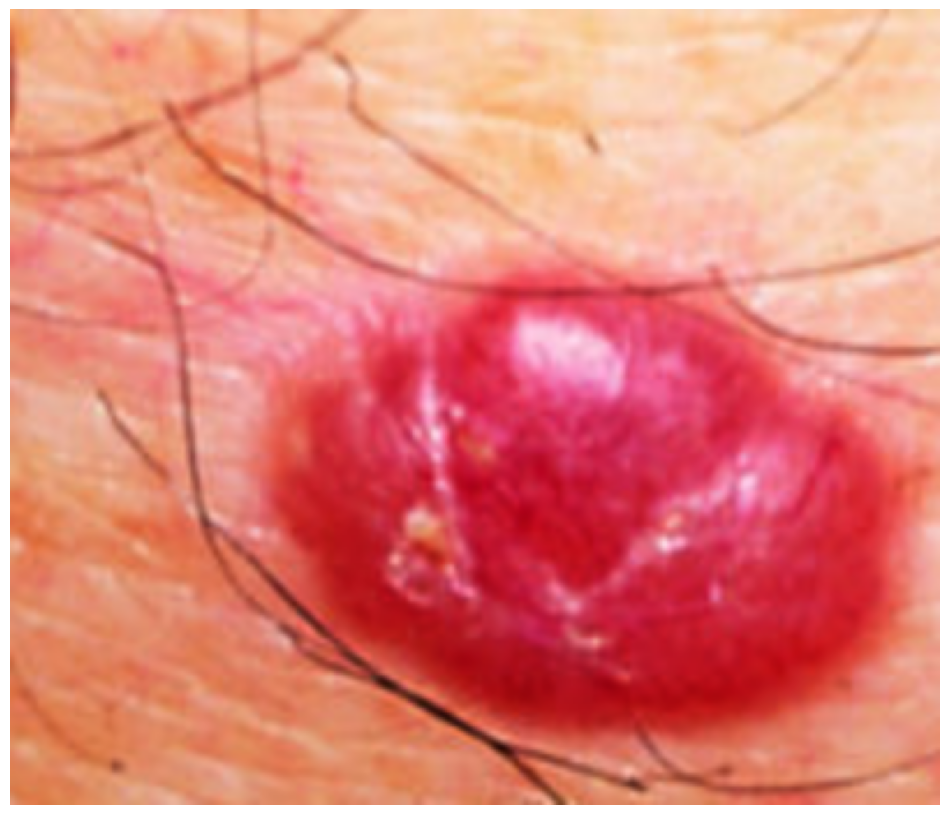

In [ ]:
from roboflow import Roboflow
import supervision as sv
import cv2, json
import numpy as np

# Roboflow 设置
rf = Roboflow(api_key="18oZy6U3mMau0dnIXs66")
project = rf.workspace().project("dermnet-segmentation")
model = project.version(2).model

# 预测
result = model.predict(r"/home/HwHiAiUser/samples/notebooks/1-Projiect/BCC基底细胞癌.jpg", confidence=40).json()

# 提取预测结果
predictions = result["predictions"]
predicyions_json = json.dumps(predictions, indent=4)
print(predictions)
boxes = []
confidences = []
class_ids = []

for pred in predictions:
    # 提取边界框坐标
    x1 = pred["x"] - pred["width"] / 2
    y1 = pred["y"] - pred["height"] / 2
    x2 = x1 + pred["width"]
    y2 = y1 + pred["height"]
    boxes.append([x1, y1, x2, y2])
    
    confidences.append(pred["confidence"])
    class_ids.append(0)  # 如果只有一个类别，使用0

# 转换为numpy数组
boxes = np.array(boxes)
confidences = np.array(confidences)
class_ids = np.array(class_ids)

# 创建Detections对象
detections = sv.Detections(
    xyxy=boxes,
    confidence=confidences,
    class_id=class_ids
)

# 创建标注器
label_annotator = sv.LabelAnnotator()
box_annotator = sv.BoxAnnotator()

# 读取图像
image = cv2.imread(r"/home/HwHiAiUser/samples/notebooks/1-Projiect/BCC基底细胞癌.jpg")

# 遍历每个检测框并截取保存
for i, box in enumerate(boxes):
    # 转换坐标为整数
    x1, y1, x2, y2 = map(int, box)
    
    # 确保坐标在图像范围内
    x1 = max(0, x1-40)
    y1 = max(0, y1-40)
    x2 = min(image.shape[1]+10, x2+10)
    y2 = min(image.shape[0]+10, y2+10)
    
    # 截取区域,并调整大小为原来的3倍
    cropped = image[y1:y2, x1:x2]
    cropped = cv2.resize(cropped, (2 * (x2 - x1), 2 * (y2 - y1)))
    
    # 保存图片
    output_path = f'cropped_{i}.jpg'
    # cv2.imwrite(output_path, cropped)
    sv.plot_image(image=cropped)
    # print(f'已保存第{i+1}个检测框区域到: {output_path}')
    
# 标注图像
labels = [pred["class"] for pred in predictions]
annotated_image = box_annotator.annotate(scene=image, detections=detections)
annotated_image = label_annotator.annotate(
    scene=annotated_image,
    detections=detections,
    labels=labels
)

# 显示结果
sv.plot_image(image=annotated_image)


In [ ]:
from ultralytics import YOLO
from PIL import Image
import cv2

if __name__ == "__main__":
    model = YOLO(r"/home/HwHiAiUser/samples/notebooks/1-Projiect/models/predict.pt")
    results = model.predict(cropped , line_width=1, conf=0.02)
    print(results)
    
    if results[0].boxes.shape[0] > 0:
        print("检测到目标")
        # BGR转RGB
        result_array = results[0].plot()
        result_array_rgb = cv2.cvtColor(result_array, cv2.COLOR_BGR2RGB)
        result_image = Image.fromarray(result_array_rgb)
        result_image.show()
        result_image.save("result.jpg")
    else:
        print("未检测到目标")

In [ ]:
import certifi
print(certifi.where())

In [ ]:
import requests
from requests.packages.urllib3.exceptions import InsecureRequestWarning

# 忽略不安全请求警告
requests.packages.urllib3.disable_warnings(InsecureRequestWarning)

url = "http://api.roboflow.com"
response = requests.post(url, verify=False)
print(response.text)